In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.testing import assert_almost_equal
import re
import sys
import time
import threading
import seaborn as sns
import mpl_toolkits
from scipy import stats
import xgboost as xgb
from scipy.stats import norm
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import  mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
pthurl =  '3rdpartyExport.csv'
DF = pd.read_csv(pthurl)

In [3]:
def train_test_val_split(Dat: DF, x: float, y: float, z: float): 
    '''dat: data
    x: train size
    y: validation size
    z: test size'''
    y_ = y / (1-x)
    z_ = z / (1-x)
    assert_almost_equal(x+y+z, 1)
    assert_almost_equal(y_+z_, 1)
    train, valtest = train_test_split(Dat, train_size=x, test_size=y+z)
    val, test = train_test_split(valtest, train_size=y_, test_size=z_)
    return train, val, test

In [4]:
class Spinner:
    busy = False
    delay = 0.1

    @staticmethod
    def spinning_cursor():
        while 1: 
            for cursor in '|/-\\': yield '.'+cursor

    def __init__(self, delay=None):
        self.spinner_generator = self.spinning_cursor()
        if delay and float(delay): self.delay = delay

    def spinner_task(self):
        while self.busy:
            sys.stdout.write(next(self.spinner_generator))
            sys.stdout.flush()
            time.sleep(self.delay)
            sys.stdout.write('\b')
            sys.stdout.flush()

    def start(self):
        self.busy = True
        threading.Thread(target=self.spinner_task).start()

    def stop(self):
        self.busy = False
        time.sleep(self.delay)

In [5]:
PTHURL = '3rdpartyExport.csv'
spin = Spinner()

In [6]:
class Data:
    ''' from a raw csv, clean it, and pick out regressands and target. train_test_split will happen in notebook as will the rest of it.
    based entirely on the excel sheet Anthony shared on day one 04-22-2019.
        here https://docs.google.com/spreadsheets/d/1T1SD2SD_Rc_AVLREZk5TaZSHVUwzw_z_zLwMJDlklak/edit?usp=sharing
    '''
    def __init__(self, csv_string):
        spin.start()
        self.dat = self.clean(pd.read_csv(csv_string))
        self.regressands = ['price_per_sq_ft', 'beds_total', 'baths.lavs',
                            'original_list_price', 'year_built',
                            'sqft-est_tot_fin', 'sqft-est_fin_abv_grd', 'acreage']
        self.X = self.dat[self.regressands]
        self.y = self.dat['sale_price']
        spin.stop()

    def clean(self, dat: pd.DataFrame) -> pd.DataFrame:
        ''''''
        def try_lower(x):
            ''''''
            try:
                return x.lower()
            except AttributeError:
                return x

        def try_float_cash(x):
            ''''''
            try:
                return float('.'.join(re.findall(r'\d+', x)))
            except TypeError:
                return x
            except ValueError:
                return x


        return (dat.assign(**{feat: dat[feat].apply(try_lower).apply(try_float_cash)
                              for feat in dat.select_dtypes(exclude=[np.number]).columns})
                .drop([x for x in dat.columns if dat[x].isna().sum()>0], axis=1)
                .rename(columns={' $/ sq ft ': 'price_per_sq_ft',
                                   '$ / sq ft for keywords': 'price_per_sq_ft_by_keyword',
                                   ' $/ sq ft .1': 'price_per_sq_ft_.1',
                                'baths.lavs': 'baths_total'})
                .rename(columns=lambda s: s.replace(' ', '_').lower().replace(':', ''))
               )

In [7]:
# transcribing from excel
row_to_keyword_mapper = {0: 'granite', 1: 'handyman', 2: 'new roof', 3: "ETC DON'T ACTULALY WANT TO TRANSCRIBE THIS"}

keywords = ['granite', 'handyman', 'new roof', ]

# Peyton says Doc2Vec from GenSim is what we want for this
# df.public_remarks

In [8]:
def clean(dat: pd.DataFrame) -> pd.DataFrame: 
    ''''''
    def try_lower(x): 
        ''''''
        try: 
            return x.lower()
        except AttributeError:
            return x

    def try_float_cash(x): 
        ''''''
        try:
            return float('.'.join(re.findall(r'\d+', x)))
        except TypeError: 
            return x
        except ValueError: 
            return x

        
    return (dat.assign(**{feat: dat[feat].apply(try_lower).apply(try_float_cash)
                          for feat in dat.select_dtypes(exclude=[np.number]).columns})
            .drop([x for x in dat.columns if dat[x].isna().sum()>0], axis=1)
            .rename(columns={' $/ sq ft ': 'price_per_sq_ft', 
                               '$ / sq ft for keywords': 'price_per_sq_ft_by_keyword', 
                               ' $/ sq ft .1': 'price_per_sq_ft_.1', 
                            'baths.lavs': 'baths_total'})
            .rename(columns=lambda s: s.replace(' ', '_').lower().replace(':', ''))
            
           )

# target: sale_price
df = clean(pd.read_csv(pthurl))

all([x==y for x,y in df[['price_per_sq_ft', 'price_per_sq_ft_.1']].values])
assert df.isna().sum().sum()==0
all([x==y for x,y in df[['sale_price', 'sale_price.1']].values])

print(df.shape)

df.head()

(955, 23)


,price_per_sq_ft,sale_price,list_price,close_date,street_number,street_name,city,county,zip5,beds_total,...,price_per_sq_ft_.1,sale_price.1,original_list_price,photo_count,pool_yn,avg,count,sqft-est_tot_fin,sqft-est_fin_abv_grd,year_built
0,98.0,170000,178000,04/16/2018,1013,genesee,royal oak,oakland,48073,3,...,98.0,170000,199900,11,False,200.0,154,1.726,1.026,1952
1,99.0,181000,179900,08/22/2018,3266,harvard,royal oak,oakland,48073,3,...,99.0,181000,199900,2,False,197.0,154,1.910,1.210,1949
2,103.0,165500,199900,12/03/2018,708,campbell,royal oak,oakland,48067,4,...,103.0,165500,199900,21,False,217.0,154,1.764,1.764,1923
3,105.0,290000,300000,06/04/2018,2607,carman,royal oak,oakland,48073,4,...,105.0,290000,325000,31,False,232.0,154,936.000,936.000,1953
4,105.0,125000,159900,04/23/2018,2931,rochester,royal oak,oakland,48073,3,...,105.0,125000,174999,25,False,155.0,3,1.792,1.064,1949


In [9]:
df.columns

Index(['price_per_sq_ft', 'sale_price', 'list_price', 'close_date',
       'street_number', 'street_name', 'city', 'county', 'zip5', 'beds_total',
       'baths.lavs', 'est_fin_abv_grd_sqft', 'acreage', 'price_per_sq_ft_.1',
       'sale_price.1', 'original_list_price', 'photo_count', 'pool_yn', 'avg',
       'count', 'sqft-est_tot_fin', 'sqft-est_fin_abv_grd', 'year_built'],
      dtype='object')

In [10]:
housing = pd.DataFrame(df)
housing.head()

,price_per_sq_ft,sale_price,list_price,close_date,street_number,street_name,city,county,zip5,beds_total,...,price_per_sq_ft_.1,sale_price.1,original_list_price,photo_count,pool_yn,avg,count,sqft-est_tot_fin,sqft-est_fin_abv_grd,year_built
0,98.0,170000,178000,04/16/2018,1013,genesee,royal oak,oakland,48073,3,...,98.0,170000,199900,11,False,200.0,154,1.726,1.026,1952
1,99.0,181000,179900,08/22/2018,3266,harvard,royal oak,oakland,48073,3,...,99.0,181000,199900,2,False,197.0,154,1.910,1.210,1949
2,103.0,165500,199900,12/03/2018,708,campbell,royal oak,oakland,48067,4,...,103.0,165500,199900,21,False,217.0,154,1.764,1.764,1923
3,105.0,290000,300000,06/04/2018,2607,carman,royal oak,oakland,48073,4,...,105.0,290000,325000,31,False,232.0,154,936.000,936.000,1953
4,105.0,125000,159900,04/23/2018,2931,rochester,royal oak,oakland,48073,3,...,105.0,125000,174999,25,False,155.0,3,1.792,1.064,1949


In [11]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 23 columns):
price_per_sq_ft         955 non-null float64
sale_price              955 non-null int64
list_price              955 non-null int64
close_date              955 non-null object
street_number           955 non-null int64
street_name             955 non-null object
city                    955 non-null object
county                  955 non-null object
zip5                    955 non-null int64
beds_total              955 non-null int64
baths.lavs              955 non-null float64
est_fin_abv_grd_sqft    955 non-null int64
acreage                 955 non-null float64
price_per_sq_ft_.1      955 non-null float64
sale_price.1            955 non-null int64
original_list_price     955 non-null int64
photo_count             955 non-null int64
pool_yn                 955 non-null bool
avg                     955 non-null float64
count                   955 non-null int64
sqft-est_tot_fin      

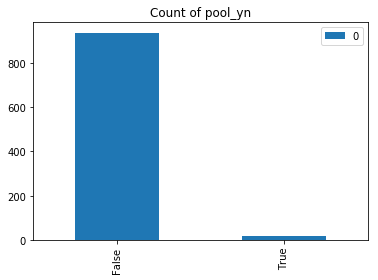

In [12]:
#Function to plot count of features:
def display_count(df,feature):
    count = Counter(df[feature])
    df_count = pd.DataFrame.from_dict(count, orient='index')
    df_count.plot(kind='bar')
    plt.title('Count of ' + feature)
    plt.show()

display_count(housing,'pool_yn')


 mu = 277281.85 and sigma = 97901.58



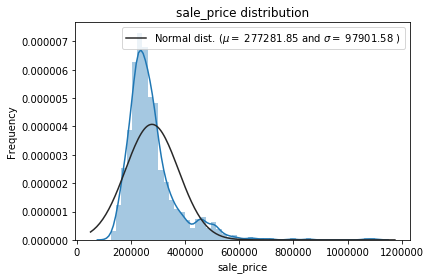

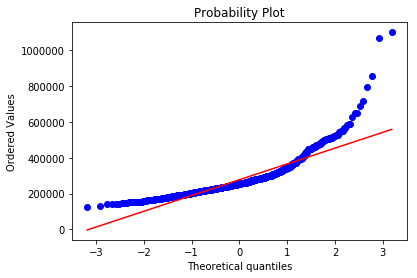

In [13]:
def normality_check(df,feature):
    sns.distplot(df[feature] , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[feature])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(str(feature) + ' distribution')

    fig = plt.figure()
    res = stats.probplot(df[feature], plot=plt)
    plt.show()
    
normality_check(housing, 'sale_price')

In [14]:
housing = housing.drop(['street_name'], axis=1)

In [15]:
def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df

housing = dummyEncode(housing)

In [16]:
X = housing.drop(['sale_price'], axis=1)
y = housing['sale_price']

In [17]:
#Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Confirming correct shapes of data
print("X_train shape is: ", (X_train.shape))
print("X_test shape is: ",(X_test.shape))
print("y_train shape is: ",(y_train.shape))
print("y_trest shape is: ",(y_test.shape))

X_train shape is:  (764, 21)
X_test shape is:  (191, 21)
y_train shape is:  (764,)
y_trest shape is:  (191,)


In [18]:
def model(pipeline, parameters, X_train, y_train, X, y):

    grid_obj = GridSearchCV(estimator=pipeline,
                            param_grid=parameters,
                            cv=3,
                            scoring='r2',
                            verbose=2,
                            n_jobs=1,
                            refit=True)
    grid_obj.fit(X_train, y_train)
    
    '''Results'''

    results = pd.DataFrame(pd.DataFrame(grid_obj.cv_results_))
    results_sorted = results.sort_values(by=['mean_test_score'], ascending=False)

    print("##### Results")
    print(results_sorted)

    print("best_index", grid_obj.best_index_)
    print("best_score", grid_obj.best_score_)
    print("best_params", grid_obj.best_params_)
    
    '''Cross Validation'''

    estimator = grid_obj.best_estimator_
    '''
    if estimator.named_steps['scl'] == True:
        X = (X - X.mean()) / (X.std())
        y = (y - y.mean()) / (y.std())
    '''
    shuffle = KFold(n_splits=5,
                    shuffle=True,
                    random_state=0)
    cv_scores = cross_val_score(estimator,
                                X,
                                y.values.ravel(),
                                cv=shuffle,
                                scoring='r2')
    print("##### CV Results")
    print("mean_score", cv_scores.mean())
    
    '''Show model coefficients or feature importances'''

    try:
        print("Model coefficients: ", list(zip(list(X), estimator.named_steps['clf'].coef_)))
    except:
        print("Model does not support model coefficients")

    try:
        print("Feature importances: ", list(zip(list(X), estimator.named_steps['clf'].feature_importances_)))
    except:
        print("Model does not support feature importances")

    '''Predict along CV and plot y vs. y_predicted in scatter'''

    y_pred = cross_val_predict(estimator, X, y, cv=shuffle)
    
    plt.scatter(y, y_pred)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
    plt.xlabel("True prices")
    plt.ylabel("Predicted prices")
    plt.annotate(' R-squared CV = {}'.format(round(float(cv_scores.mean()), 3)), size=9,
             xy=(xmin,ymax), xytext=(10, -15), textcoords='offset points')
    plt.annotate(grid_obj.best_params_, size=9,
                 xy=(xmin, ymax), xytext=(10, -35), textcoords='offset points', wrap=True)
    plt.title('Predicted prices  vs. True prices')
    plt.show()

In [19]:
# Pipeline and Parameters - Linear Regression

pipe_ols = Pipeline([('scl', StandardScaler()),
           ('clf', LinearRegression())])

param_ols = {}

In [20]:
# Pipeline and Parameters - XGBoost

pipe_xgb = Pipeline([('clf', xgb.XGBRegressor())])

param_xgb = {'clf__max_depth':[5],
             'clf__min_child_weight':[6],
             'clf__gamma':[0.01],
             'clf__subsample':[0.7],
             'clf__colsample_bytree':[1]}

In [21]:
# Pipeline and Parameters - KNN

pipe_knn = Pipeline([('clf', KNeighborsRegressor())])

param_knn = {'clf__n_neighbors':[5, 10, 15, 25, 30]}

In [22]:
# Pipeline and Parameters - Lasso

pipe_lasso = Pipeline([('scl', StandardScaler()),
           ('clf', Lasso(max_iter=1500))])
param_lasso = {'clf__alpha': [0.01, 0.1, 1, 10]}

In [23]:
# Pipeline and Parameters - Ridge

pipe_ridge = Pipeline([('scl', StandardScaler()),
           ('clf', Ridge())])

param_ridge = {'clf__alpha': [0.01, 0.1, 1, 10]}

In [24]:
# Pipeline and Parameters - Polynomial Regression

pipe_poly = Pipeline([('scl', StandardScaler()),
                       ('polynomial', PolynomialFeatures()),
                       ('clf', LinearRegression())])

param_poly = {'polynomial__degree': [2, 4, 6]}

In [25]:
# Pipeline and Parameters - Decision Tree Regression

pipe_tree = Pipeline([('clf', DecisionTreeRegressor())])

param_tree = {'clf__max_depth': [2, 5, 10],
             'clf__min_samples_leaf': [5,10,50,100]}

In [26]:
# Pipeline and Parameters - Random Forest

pipe_forest = Pipeline([('clf', RandomForestRegressor())])

param_forest = {'clf__n_estimators': [10, 20, 50],
                'clf__max_features': [None, 1, 2],
                'clf__max_depth': [1, 2, 5]}

In [27]:
# Pipeline and Parameters - MLP Regression

pipe_neural = Pipeline([('scl', StandardScaler()),
                        ('clf', MLPRegressor())])

param_neural = {'clf__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                'clf__hidden_layer_sizes': [(5),(10,10),(7,7,7)],
                'clf__solver': ['lbfgs'],
                'clf__activation': ['relu', 'tanh'],
                'clf__learning_rate' : ['constant', 'invscaling']}

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
0       0.018802       0.00202          0.00406        0.001294     {}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0                1.0                1.0                1.0              1.0   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0             0.0                1                 1.0                 1.0   

   split2_train_score  mean_train_sc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


##### CV Results
mean_score 1.0
Model coefficients:  [('price_per_sq_ft', 1.887201506178826e-11), ('list_price', 2.0236257114447653e-11), ('close_date', -1.3642420526593924e-11), ('street_number', 9.094947017729282e-12), ('city', 4.915186434801652e-11), ('county', 4.061045241816686e-11), ('zip5', 3.183231456205249e-12), ('beds_total', 3.637978807091713e-12), ('baths.lavs', 1.6370904631912708e-11), ('est_fin_abv_grd_sqft', -2.000888343900442e-11), ('acreage', -5.9117155615240335e-12), ('price_per_sq_ft_.1', 1.0686562745831907e-11), ('sale_price.1', 100226.77143892102), ('original_list_price', -6.730260793119669e-11), ('photo_count', 1.000444171950221e-11), ('pool_yn', 1.3642420526593924e-11), ('avg', -8.640199666842818e-12), ('count', 9.094947017729282e-12), ('sqft-est_tot_fin', 5.6843418860808015e-12), ('sqft-est_fin_abv_grd', 1.3642420526593924e-12), ('year_built', -9.094947017729282e-12)]
Model does not support feature importances


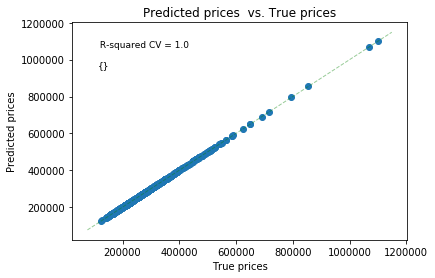

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7 
[CV]  clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7, total=   0.1s
[CV] clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7, total=   0.1s
[CV] clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7 
[CV]  clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7, total=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.135938      0.006326         0.003377         0.00009   

  param_clf__colsample_bytree param_clf__gamma param_clf__max_depth  \
0                           1             0.01                    5   

  param_clf__min_child_weight param_clf__subsample  \
0                           6                  0.7   

                                              params  ...  split1_test_score  \
0  {'clf__colsample_bytree': 1, 'clf__gamma': 0.0...  ...            0.99258   

   split2_test_score  mean_test_score  std_test_score  rank_test_score  \
0           0.993801         0.966762         0.03734                1   

   split0_train_score  split1_train_score  split2_train_score  \
0             0.99361            0.991108            0.992785   

   mean_train_score  std_train_score  
0          0.992501         0.001041  

[1 rows x 21 columns]
best_index 0
best_score 0.966762007510205
best_params {'c

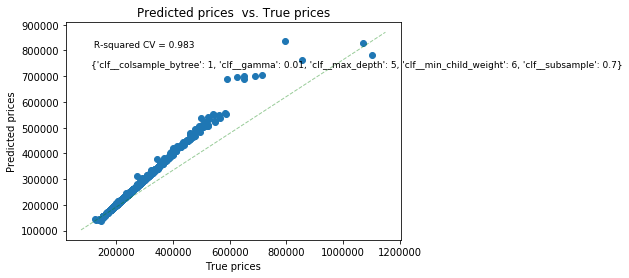

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=   0.0s
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=   0.0s
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=   0.0s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=   0.0s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=   0.0s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=   0.0s
[CV] clf__n_neighbors=15 .............................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] clf__n_neighbors=25 .............................................
[CV] .............................. clf__n_neighbors=25, total=   0.0s
[CV] clf__n_neighbors=25 .............................................
[CV] .............................. clf__n_neighbors=25, total=   0.0s
[CV] clf__n_neighbors=30 .............................................
[CV] .............................. clf__n_neighbors=30, total=   0.0s
[CV] clf__n_neighbors=30 .............................................
[CV] .............................. clf__n_neighbors=30, total=   0.0s
[CV] clf__n_neighbors=30 .............................................
[CV] .............................. clf__n_neighbors=30, total=   0.0s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.007768      0.000048         0.006534        0.001717   
1       0.004849      0.000829         0.004171        0.000137   
2       0.004470      0.000906         0.004508        0.000282   
3      

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished


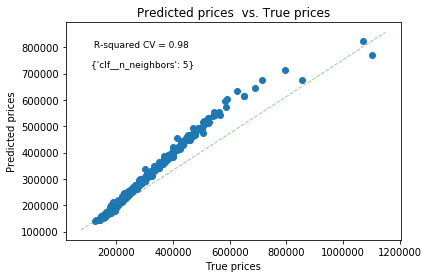

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.0s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.0s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.0s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.0s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.0s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.0s
[CV] clf__alpha=1 ....................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... clf__alpha=1, total=   0.0s
[CV] clf__alpha=1 ....................................................
[CV] ..................................... clf__alpha=1, total=   0.0s
[CV] clf__alpha=10 ...................................................
[CV] .................................... clf__alpha=10, total=   0.0s
[CV] clf__alpha=10 ...................................................
[CV] .................................... clf__alpha=10, total=   0.0s
[CV] clf__alpha=10 ...................................................
[CV] .................................... clf__alpha=10, total=   0.0s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       0.013443      0.000866         0.003210        0.000575   
2       0.020766      0.003265         0.004772        0.000536   
1       0.014948      0.000895         0.003245        0.000240   
0       0.017632      0.002721         0.003644        0.001752   

  param_clf

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s finished


##### CV Results
mean_score 0.9999997364510408
Model coefficients:  [('price_per_sq_ft', 0.0), ('list_price', 315.195197098341), ('close_date', 0.0), ('street_number', -0.0), ('city', 0.0), ('county', 0.0), ('zip5', -0.0), ('beds_total', -0.0), ('baths.lavs', -0.0), ('est_fin_abv_grd_sqft', 227.32339180626008), ('acreage', -0.0), ('price_per_sq_ft_.1', 130.09044626315313), ('sale_price.1', 99662.03765663665), ('original_list_price', 0.0), ('photo_count', -0.0), ('pool_yn', -0.0), ('avg', 0.0), ('count', 0.0), ('sqft-est_tot_fin', -0.0), ('sqft-est_fin_abv_grd', -0.0), ('year_built', 0.0)]
Model does not support feature importances


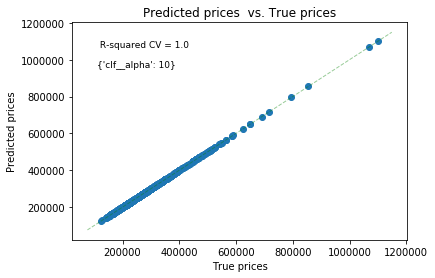

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.0s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.0s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.0s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.0s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.0s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.0s
[CV] clf__alpha=1 ....................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... clf__alpha=10, total=   0.0s
[CV] clf__alpha=10 ...................................................
[CV] .................................... clf__alpha=10, total=   0.0s
[CV] clf__alpha=10 ...................................................
[CV] .................................... clf__alpha=10, total=   0.0s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.011800      0.001662         0.003369        0.000079   
1       0.011080      0.001306         0.004015        0.001005   
2       0.010317      0.001098         0.003235        0.000198   
3       0.012135      0.001785         0.002876        0.000641   

  param_clf__alpha                params  split0_test_score  \
0             0.01  {'clf__alpha': 0.01}           1.000000   
1              0.1   {'clf__alpha': 0.1}           0.999996   
2                1     {'clf__alpha': 1}           0.999799   
3               10    {'clf__alpha': 10}   

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s finished


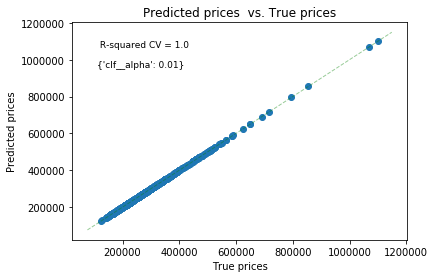

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] polynomial__degree=2 ............................................
[CV] ............................. polynomial__degree=2, total=   0.1s
[CV] polynomial__degree=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................. polynomial__degree=2, total=   0.1s
[CV] polynomial__degree=2 ............................................
[CV] ............................. polynomial__degree=2, total=   0.1s
[CV] polynomial__degree=4 ............................................
[CV] ............................. polynomial__degree=4, total=   3.7s
[CV] polynomial__degree=4 ............................................
[CV] ............................. polynomial__degree=4, total=   3.0s
[CV] polynomial__degree=4 ............................................
[CV] ............................. polynomial__degree=4, total=   3.4s
[CV] polynomial__degree=6 ............................................


In [ ]:
# Execute model hyperparameter tuning and crossvalidation

model(pipe_ols, param_ols, X_train, y_train, X, y)
model(pipe_xgb, param_xgb, X_train, y_train, X, y)
model(pipe_knn, param_knn, X_train, y_train, X, y)
model(pipe_lasso, param_lasso, X_train, y_train, X, y)
model(pipe_ridge, param_ridge, X_train, y_train, X, y)
model(pipe_poly, param_poly, X_train, y_train, X, y)
model(pipe_tree, param_tree, X_train, y_train, X, y)
model(pipe_forest, param_forest, X_train, y_train, X, y)
model(pipe_neural, param_neural, X_train, y_train, X, y)